<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Intraday Futures Calendar Spreads](Introduction.ipynb) › Part 5: Moonshot Native Spread Strategy
***

# Moonshot Native Spread Strategy

To run the earlier Moonshot strategy on a native calendar spread requires modified code because we are now trading a single instrument instead of multiple instruments. The modified code is provided in [calspread_native.py](calspread_native.py). 

## Code highlights

### Target weights
Moonshot expects target weights to be defined as a percentage of capital: for example, a target weight of 0.10 tells Moonshot to buy a number of futures contracts equal to 10% of capital, based on the contract's price and multiplier. This presents a problem for native combos, as the combo price is often a small number (specifically, the difference in price of the two legs), which can result in Moonshot calculating a large number of contracts that should be ordered. 

The recommended solution is to specify the exact number of spread contracts to order, rather than relying on percentage weights. To accomplish this, we first set the percentage weights extremely high in `signals_to_target_weights`:
    
```python
def signals_to_target_weights(self, signals, prices):
    weights = signals * 1000
    return weights
```

Then, we reduce the weights to the exact desired quantities (in this example 1 contract) in `limit_position_sizes`:

```python
def limit_position_sizes(self, prices):
    """
    Limit the position sizes to 1 spread contract.

    (Note that limit_position_sizes only cares about absolute values so no need
    to worry about signs.)
    """
    bids = prices.loc["BidPriceClose"]
    ones = pd.DataFrame(1, index=bids.index, columns=bids.columns)
    max_quantities_for_longs = max_quantities_for_shorts = ones
    return max_quantities_for_longs, max_quantities_for_shorts
```

### Orders
To support live/paper trading, the native spread strategy defines an `order_stubs_to_orders` method which routes orders to NYMEX, ensuring the combo orders are executed as native orders (see the usage guide to learn more):

```python
def order_stubs_to_orders(self, orders, prices):
    orders["Exchange"] = "NYMEX"
    orders["OrderType"] = "MKT"
    orders["Tif"] = "DAY"
    return orders
```

### Install strategy file

Install the strategy by moving it to the `/codeload/moonshot` directory:

In [1]:
!mv calspread_native.py /codeload/moonshot/

## Example Backtest

After collecting an adequate amount of real-time data (at least enough to cover `BBAND_LOOKBACK_WINDOW`), it is possible to run a backtest of the modified strategy. To generate trading activity for the backtest, we use the `params` argument to reset some parameters on-the-fly to lower their thresholds:

In [2]:
from quantrocket.moonshot import backtest
backtest("calspread-native-cl", 
         filepath_or_buffer="calspread_native_cl_results.csv", 
         params={
             "BBAND_LOOKBACK_WINDOW":10,
             "BBAND_STD": 1},
         nlv={"USD":500000},
         details=True)

Then we see if there were any trades:

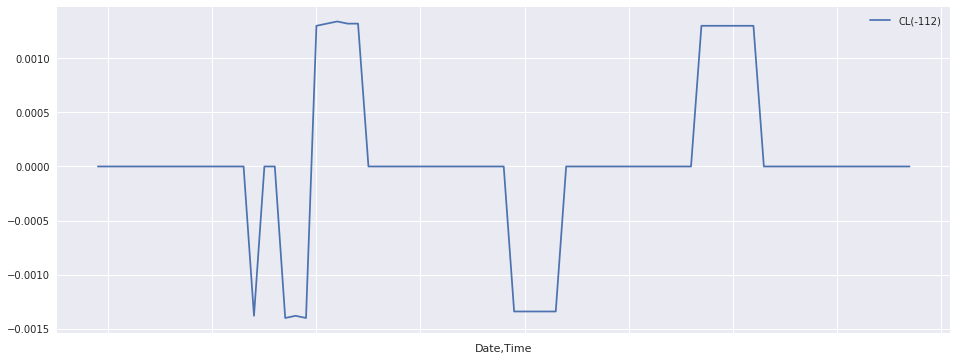

In [3]:
from quantrocket.moonshot import read_moonshot_csv
results = read_moonshot_csv("calspread_native_cl_results.csv")
results.loc["NetExposure"].plot()

## Account allocation

To trade the strategy, we must allocate `calspread-native-cl` to one or more accounts. Open [quantrocket.moonshot.allocations.yml](quantrocket.moonshot.allocations.yml), edit the account number to match your live or paper IB account, and edit the capital allocation percentage as desired.

If you don't already have a `quantrocket.moonshot.allocations.yml` in the `/codeload` directory (i.e. top level of the Jupyter file browser), you can execute the following command to copy it over. Otherwise, append the new allocation to your existing file.

In [1]:
# move file over unless it already exists
![ -e /codeload/quantrocket.moonshot.allocations.y*ml ] && echo 'oops, the file already exists!' || mv quantrocket.moonshot.allocations.yml /codeload/

## Generate Moonshot orders

Next we can run Moonshot's `trade` command to generate example orders. 

First, we check the backtest results for a time when a signal was generated: 

In [4]:
signals = results.loc["Signal"]
signals.where(signals != 0).dropna().head()

CL(IC1)
Date       Time              
2019-09-23 16:03:00      -1.0
           16:07:00      -1.0
           16:17:00      -1.0
           16:22:00      -1.0
2019-09-24 08:14:00       1.0

For testing purposes, edit the strategy file so that the strategy parameters match those used to produce the backtest results (`BBAND_WINDOW = 10` and `BBAND_STD = 1` were the parameters we set on-the-fly in this example).  

Then we can use the `--review-date` parameter to tell Moonshot to generate orders as if it were one of the above example times. Moonshot returns a CSV of orders, which we format for the terminal with `csvlook`:

In [5]:
!quantrocket moonshot trade 'calspread-native-cl' --review-date '2019-09-23 16:17:00' | csvlook -I

| Sid | Account | Action | OrderRef            | TotalQuantity | Exchange | OrderType | Tif |
| --- | ------- | ------ | ------------------- | ------------- | -------- | --------- | --- |
| IC1 | DU12345 | SELL   | calspread-native-cl | 1             | NYMEX    | MKT       | DAY |


***

## *Next Up*

Part 6: [Scheduling](Part6-Scheduling.ipynb)